# Sports match video to text summarization

In this project we try to summarise video to text using alexnet with transform lerning.
procedure that we follow is as below:
1. Prepare dataset from sport videos
2. Create one model and pass this preprocess dataset
3. Predict the class of input frame

In our project we follow this research paper.
link: https://www.mdpi.com/1424-8220/20/6/1702/htm

In [1]:
#This are some required libraries
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage import io
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pickle

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset preparation

First we fetch the dataset from folder are divide them in train set and test set.
During preprocessing we resize our images to 224x224 size. Batch size is 32.

In [3]:
"""
In this cell we open the dataset and display the sample image. Also, make one list of class lables.
"""

data_dir = pathlib.Path("/content/drive/MyDrive/new_dataset")
clas = ["Batting or Bowling","Boundary"]
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

4940


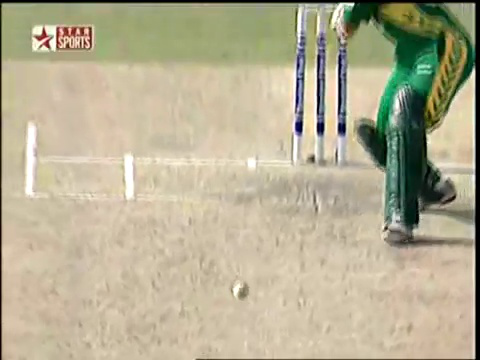

In [4]:
Bat = list(data_dir.glob('Batting/*'))
PIL.Image.open(str(Bat[1]))

In [5]:
"""
Information of dataset preprocessing.
"""
batch_size = 32
img_height = 224
img_width = 224

In [6]:
"""
Here, we divide our dataset in training set.
"""

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,)
print(len(train_ds))

Found 4940 files belonging to 2 classes.
Using 3952 files for training.
124


In [7]:
"""
Here, we divide our dataset in test set.
"""

test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4940 files belonging to 2 classes.
Using 988 files for validation.


# Experiment

Here we do one experiment on the dataset. That is we augment each image. In augmentation we flip the image in horizontally or vertically. In below cell code for that but it is not running on machine due to heavy load. So, we drop this idea.

In [8]:
AUTOTUNE = tf.data.AUTOTUNE
data_augmentation = keras.Sequential([
  keras.layers.RandomFlip("horizontal_and_vertical"),
])
aug_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y),num_parallel_calls=AUTOTUNE)
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


# Model Information

As per the research paper we have to use pre trainded alexnet model with imagenet. After that we have to apply the transform learning. But We want to know how alexnet work directly on this dataset. So, we created whole model from scratch. We got around 50% acc.

In [9]:
"""
For model creation we use tensorflow 2.x with keras. we follow this tutorial for this 'https://www.tensorflow.org/tutorials/images/classification'.
"""

pre_trained_model = tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

58900480/58889256 [==============================] - 1s 0us/step


In [10]:
for layer in pre_trained_model.layers:
    print(layer.name)
    layer.trainable = False

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [11]:
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(2, activation='sigmoid')(x)

In [12]:
model = tf.keras.Model(pre_trained_model.input, x)

# Saving the model

Due to limited resources we train our model partly.At the end of each part we store our model weights in file. Logic for that is given below.

In [13]:
"""
For checkpointing we created a callback function. 
"""
checkpoint_path = "/content/drive/MyDrive/training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


In [14]:
"""
By running this you can watch out the model summary.
"""

model.compile(optimizer='adam', loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['acc'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# Traning the model

Here we train our model. At the end of 10 epoch we store our model weight in file. Also we store the model history in file.In total we execute 20 epoch and we get 50% acc.

In [15]:
cou = 0
if os.path.exists('/content/drive/MyDrive/training'):
    model.load_weights(checkpoint_path)
history  = model.fit(train_ds,
epochs = 10,
validation_data=test_ds,
batch_size = batch_size,
verbose = 1,
callbacks=[cp_callback])
with open('/content/drive/MyDrive/trainHistoryDict_'+str(cou), 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

Epoch 1/10
124/124 [==============================] - ETA: 0s - loss: 4.8059 - acc: 0.9205
Epoch 00001: saving model to /content/drive/MyDrive/training/cp.ckpt
124/124 [==============================] - 1277s 10s/step - loss: 4.8059 - acc: 0.9205 - val_loss: 0.7795 - val_acc: 0.9727
Epoch 2/10
124/124 [==============================] - ETA: 0s - loss: 0.6086 - acc: 0.9704
Epoch 00002: saving model to /content/drive/MyDrive/training/cp.ckpt
124/124 [==============================] - 38s 293ms/step - loss: 0.6086 - acc: 0.9704 - val_loss: 0.3872 - val_acc: 0.9818
Epoch 3/10
124/124 [==============================] - ETA: 0s - loss: 0.3344 - acc: 0.9777
Epoch 00003: saving model to /content/drive/MyDrive/training/cp.ckpt
124/124 [==============================] - 37s 293ms/step - loss: 0.3344 - acc: 0.9777 - val_loss: 0.2874 - val_acc: 0.9858
Epoch 4/10
124/124 [==============================] - ETA: 0s - loss: 0.2311 - acc: 0.9800
Epoch 00004: saving model to /content/drive/MyDrive/train

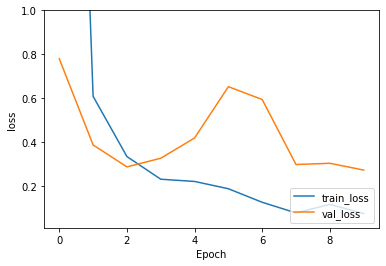

In [7]:
shistory = pickle.load(open('/content/drive/MyDrive/trainHistoryDict_0', "rb"))
plt.plot(shistory['loss'], label='train_loss')
plt.plot(shistory['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0.01, 1])
plt.legend(loc='lower right')

# Testing the model

Here we test our model and get around 51% acc.

In [17]:
test_loss, test_acc = model.evaluate(test_ds, verbose=2)

31/31 - 8s - loss: 0.2729 - acc: 0.9828 - 8s/epoch - 265ms/step


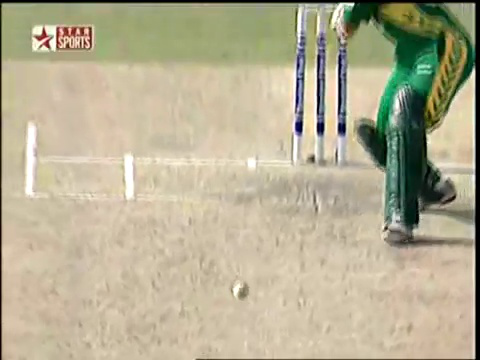

In [18]:
p = list(data_dir.glob('Batting/*'))
PIL.Image.open(str(p[1]))

In [20]:
img_path = '/content/drive/MyDrive/new_dataset/Boundary/frame565.jpg'
img = tf.keras.utils.load_img(
    img_path, target_size=(224, 224)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(score)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(clas[np.argmax(score)], 100 * np.max(score))
)

tf.Tensor([0.26894143 0.73105854], shape=(2,), dtype=float32)
This image most likely belongs to Boundary with a 73.11 percent confidence.
